# 1. Perkenalan

=======================================================================
Milestone 2

Nama        : Muhammad Rozzaaq\
Batch       : RMT-033\
Objective   : Objek dari program ini adalah membuat model untuk memprediksi apakah responden mengidap diabetes apa tidak


=======================================================================


# 2. Import Libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau

from sklearn.model_selection import train_test_split

# Scaler & Encoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import joblib


# 3. Data Loading


In [2]:
df_ori = pd.read_csv('diabetes_prediction_dataset.csv')
df = df_ori
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [59]:
df['HbA1c_level'].unique().max()

np.float64(9.0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Tipe data sudah sesuai. maka tidak dilakukan normalisasi data

In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [67]:
df.duplicated().sum()

np.int64(3854)

Terdapat 3,854 duplicated data. selanjutnya data yang terduplikasi akan di drop.

In [3]:
df = df.drop_duplicates()

In [4]:
df.duplicated().sum()

np.int64(0)

In [96]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


# 4. Exploratory Data Analysis (EDA)

### Meta Data

```
gender                  : Jenis kelamin responden
age                     : Usia responden
hypertension            : Kondisi dimana responden memiliki tekanan darah tinggi atau tidak. (1=True/memiliki tekanan darah tinggi, 0=False/Tidak memiliki tekanan darah tinggi)
heart_disease           : Kondisi dimana responden memiliki penyakit jantung atau tidak. (1=True/memiliki penyakit jantung, 0=False/Tidak memiliki penyakit jantung)
smoking_history         : Riwayat merokok. Menggambarkan apakah responden pernah merokok atau tidak.
bmi                     : Body Mass Index (Indeks Massa Tubuh), Indikator apakah responden obesitas atau tidak. Hasil dari tinggi di bagi berat badan. 
HbA1c_level             : Kadar HbA1c (Hemoglobin A1c), Ukuran kadar gula darah rata-rata seseorang selama 2-3 bulan terakhir.
blood_glucose_level     : Kadar glukosa darah, Jumlah glukosa dalam aliran darah pada waktu tertentu.
diabetes                : 
```

In [5]:
df_eda = df.copy()

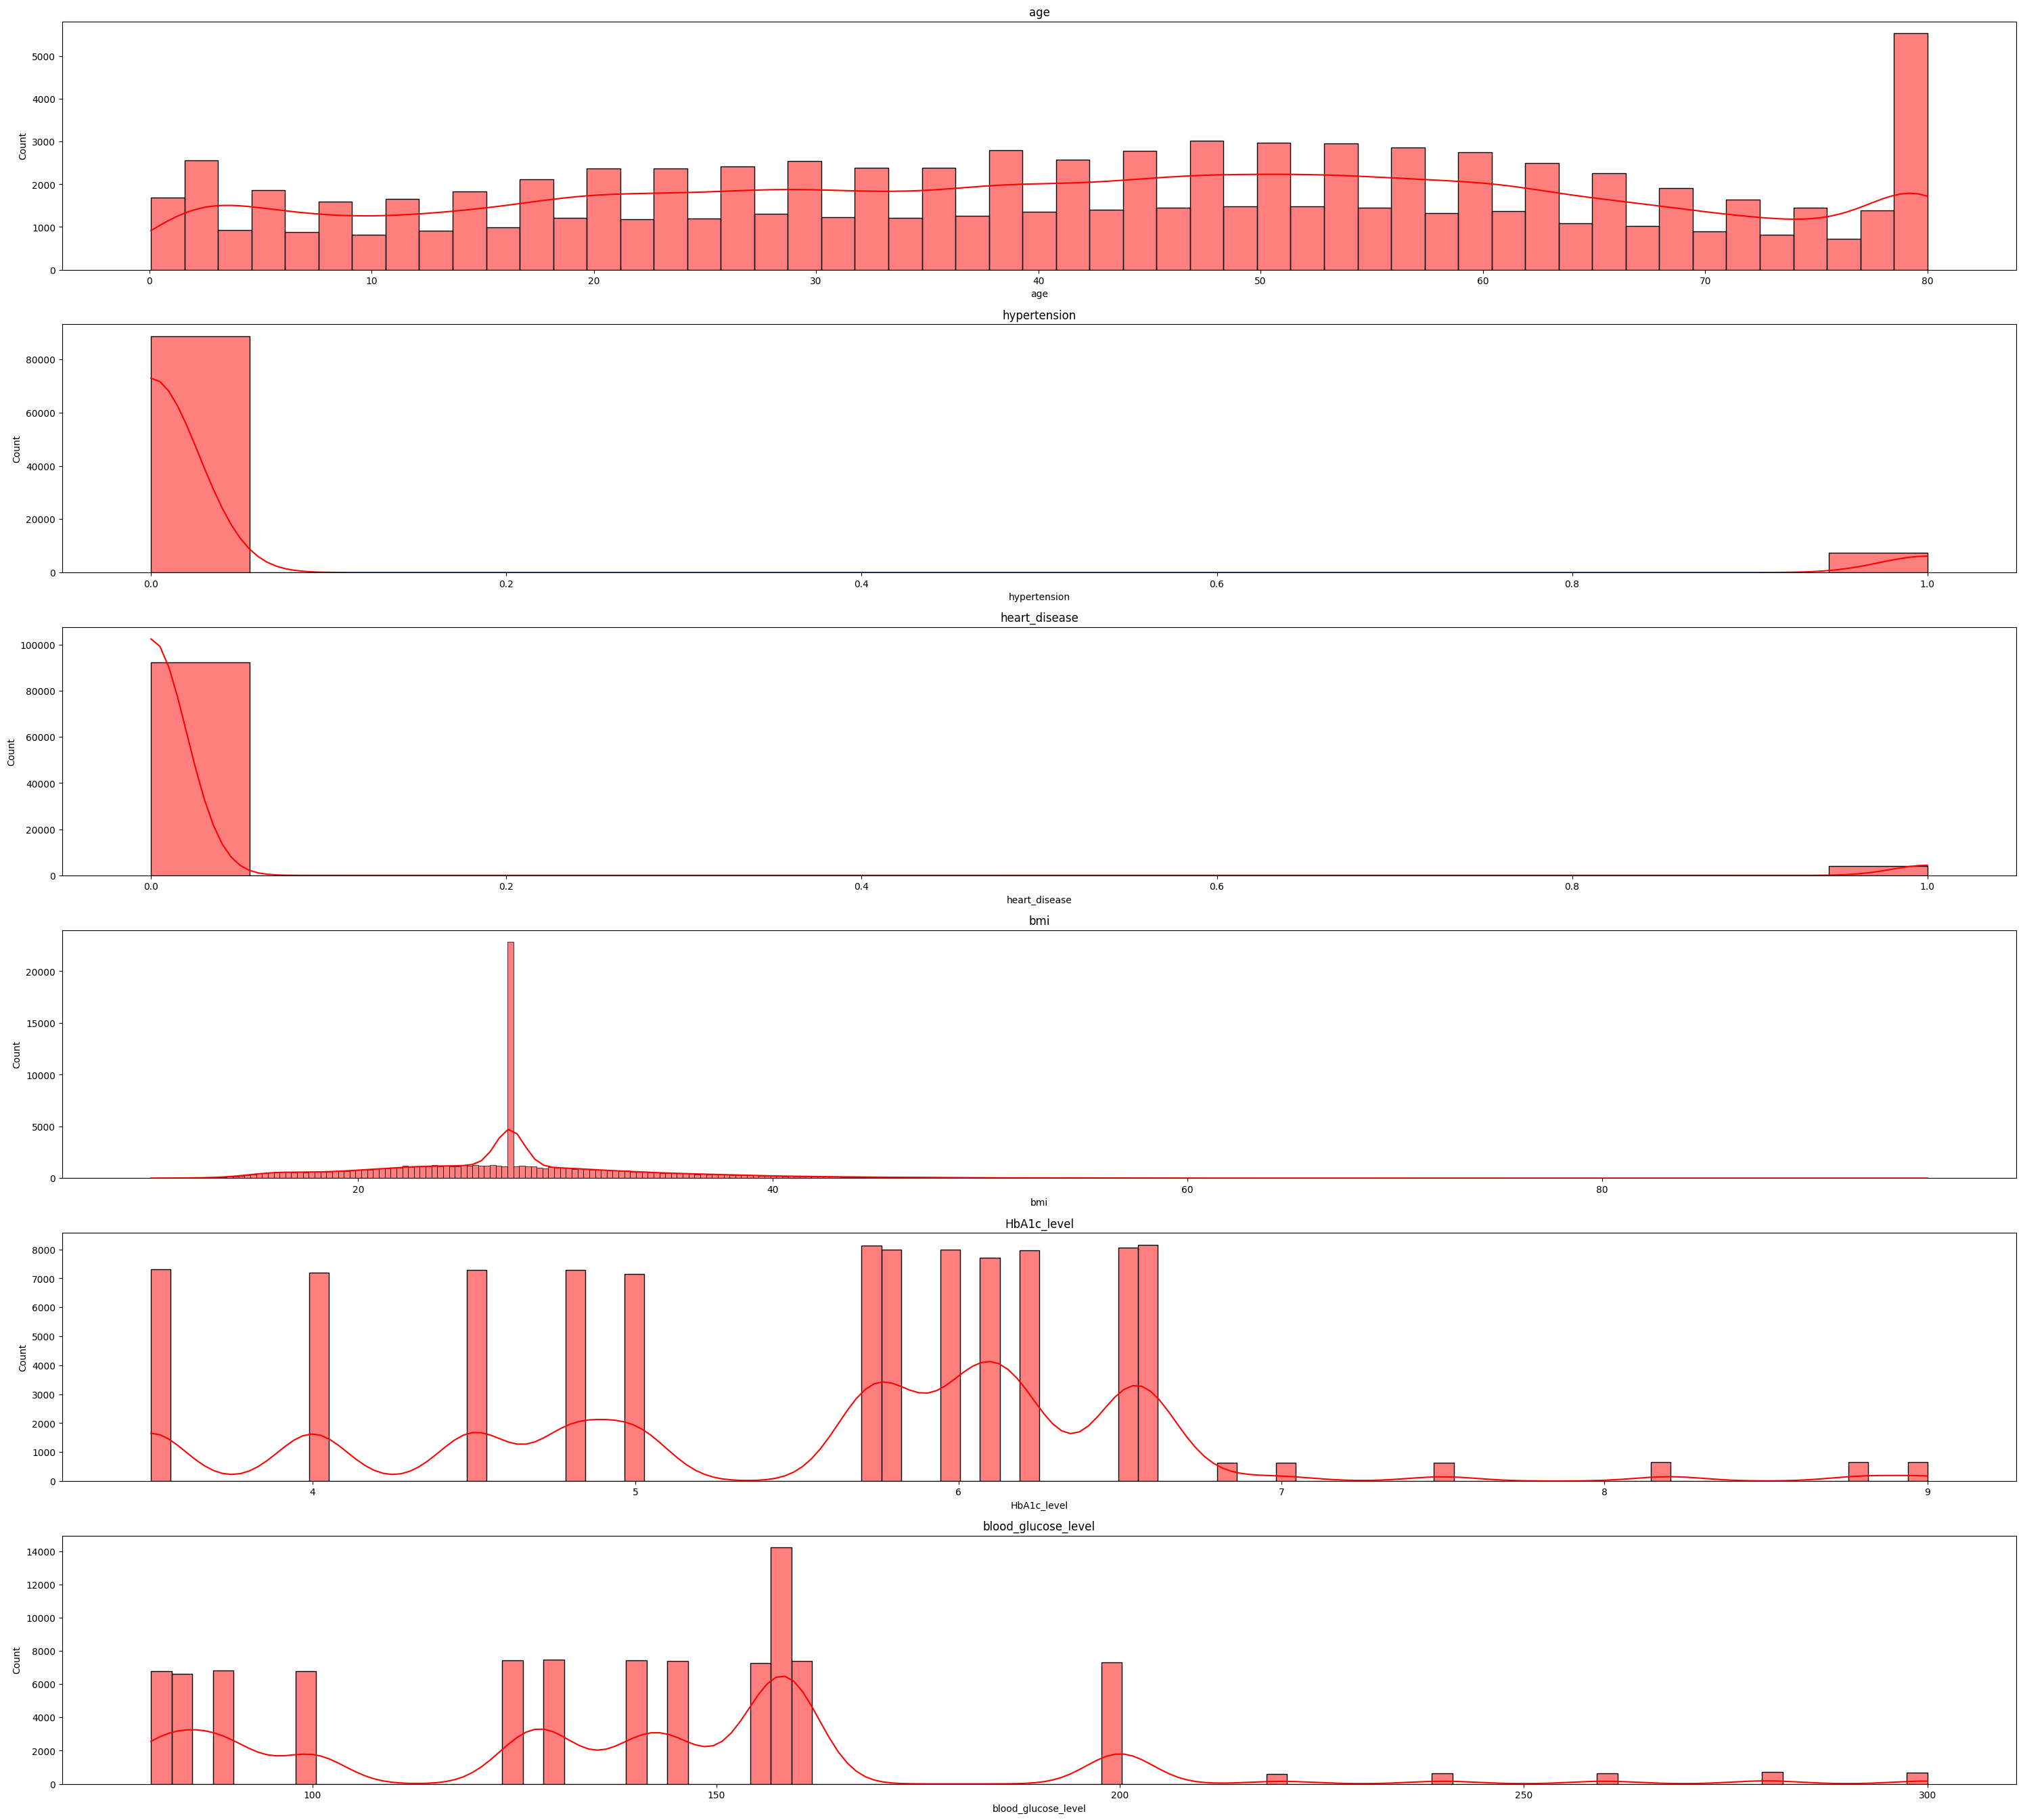

In [6]:
cent = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
plt.figure(figsize=(30, 40))

# Histogram
for i, col in enumerate(cent):
    plt.subplot(9, 1, i+1)
    sns.histplot(df[col],  color='red', edgecolor='black', kde=True)
    plt.title(col)

# Layout
plt.tight_layout()
plt.show()

In [98]:
df_eda['bmi'].value_counts()

bmi
27.32    21666
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
56.10        1
50.27        1
55.04        1
56.65        1
53.37        1
Name: count, Length: 4247, dtype: int64

Pada kolom Hypertension terlihat sebagian besar responden tidak memiliki teknn darah tinggi\
Pada kolom Heart_Deases juga terlihat sebagian besar responden tidak memiliki serangan jantung\
Pada kolom bmi, responden dengan nilai bmi 27.32 adalah yang terbanyak. 

In [99]:
# Melihat kategori bmi

def bmi_cat(bmi):
    if bmi < 24.9:
        return 'normal'
    if 24.9 <= bmi <= 29.9:
        return 'overweight'
    elif bmi > 30:
        return 'obesitas'
    
df_eda['bmi_cat'] = df_eda['bmi'].apply(bmi_cat)
df_eda

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,bmi_cat
0,Female,80.0,0,1,never,25.19,6.6,140,0,overweight
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,overweight
2,Male,28.0,0,0,never,27.32,5.7,158,0,overweight
3,Female,36.0,0,0,current,23.45,5.0,155,0,normal
4,Male,76.0,1,1,current,20.14,4.8,155,0,normal
...,...,...,...,...,...,...,...,...,...,...
99994,Female,36.0,0,0,No Info,24.60,4.8,145,0,normal
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0,normal
99997,Male,66.0,0,0,former,27.83,5.7,155,0,overweight
99998,Female,24.0,0,0,never,35.42,4.0,100,0,obesitas


In [58]:
df_eda['diabetes'].value_counts()

diabetes
0    87664
1     8482
Name: count, dtype: int64

Mencoba melihat status responden berdasarkan bmi, terlihat bahwa responden dengan status overweight adalah reponden terbanyk.  

In [102]:
numeric_desc = ['hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
central_tend = df_eda[numeric_desc].describe().loc[['min', 'max', '50%', 'mean']]

# menambahkan skewness
central_tend.loc['skew'] = df_eda[numeric_desc].skew()
central_tend

,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
min,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
max,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000
50%,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
mean,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
skew,3.157676,4.642359,1.023751,-0.054463,0.836489,2.903845


Terdapat skew.Ini berarti persebaran data tidak normal.nantinya akan berpengaruh dalam menentukan scaler

In [81]:
kategorik = ['gender', 'age', 'smoking_history', 'diabetes']

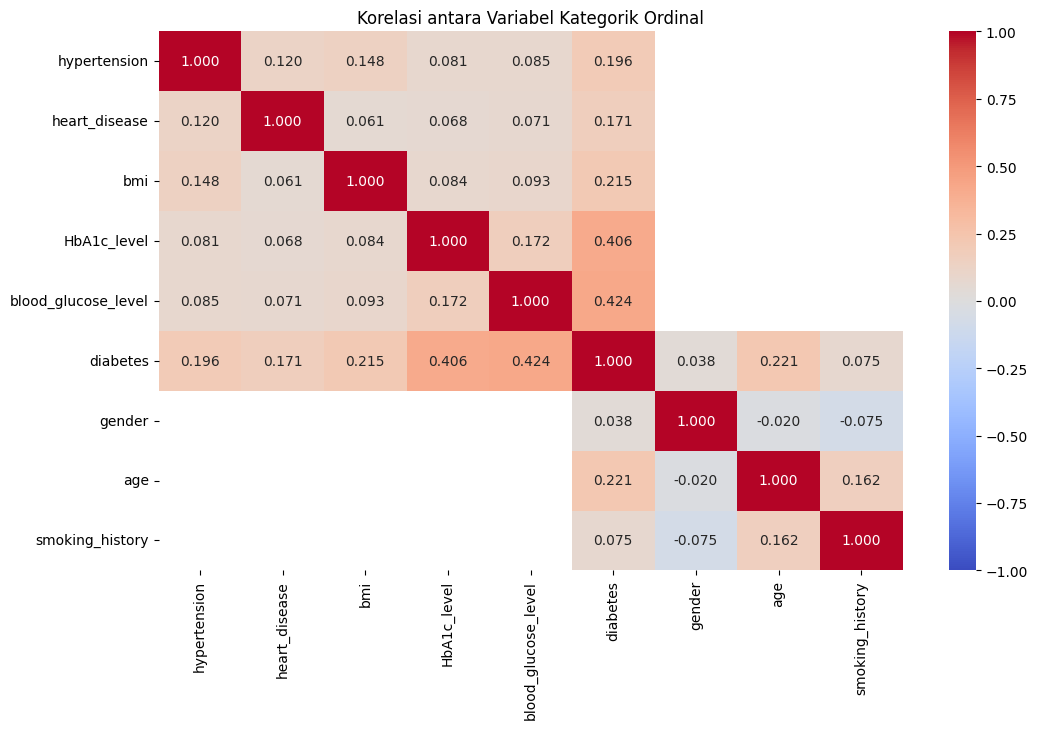

In [85]:
# Menghitung korelasi Kendall untuk setiap pasangan kolom
for col1 in kategorik:
    for col2 in kategorik:
        if col1 != col2:
            corr, _ = kendalltau(df[col1], df[col2])
            correlation_matrix.loc[col1, col2] = corr
        else:
            correlation_matrix.loc[col1, col2] = 1.0  # Korelasi diri sendiri adalah 1

# Mengubah tipe data menjadi float
correlation_matrix = correlation_matrix.astype(float)

# Membuat heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.3f')
plt.title('Korelasi antara Variabel Kategorik Ordinal')
plt.show()

Seluruh kolom memiliki korelasi terhadap kolom diabetes keculai gender. kolom gender memiliki tingkat korelasi yang sangat kecil. 

# 5. Feature Engineering

## 5.1. Feature Selection

In [4]:
df_select = df[['age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]
df_select

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80.0,0,1,never,25.19,6.6,140,0
1,54.0,0,0,No Info,27.32,6.6,80,0
2,28.0,0,0,never,27.32,5.7,158,0
3,36.0,0,0,current,23.45,5.0,155,0
4,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...
99994,36.0,0,0,No Info,24.60,4.8,145,0
99996,2.0,0,0,No Info,17.37,6.5,100,0
99997,66.0,0,0,former,27.83,5.7,155,0
99998,24.0,0,0,never,35.42,4.0,100,0


Tidak memilih gender dalam feature selection karena berdasarkan nilai kendall-tau, gender menunjukan korelasi yang sangat kecil terhadap diabetes.

## 5.2. Handling Misiing Value

In [88]:
df_select.isnull().sum()

age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Kami tidak melakukan handling missing value karena tidak ditmukan missing value

## 5.3.Handling Outliers

In [89]:
for i in numeric_desc:
    q1 = df_select[i].quantile(0.25)
    q3 = df_select[i].quantile(0.75)
    iqr = q3-q1

    up_bound = q3 + 1.5*iqr
    low_bound = q1 - 1.5*iqr
    print(f'Upper Boundary: {up_bound:.2f}' )
    print(f'Lower Boundary: {low_bound:.2f}')

    outlier = df_select[i][(df_select[i]<low_bound) | (df_select[i]>up_bound)]
    no_outlier = df_select[i][(df_select[i]>=low_bound) & (df_select[i]<=up_bound)]

    print(f'Percentage of outliers of {i}: {len(outlier)*100/len(df_select[i]):.2f}%%')
    print('\n')

Upper Boundary: 0.00
Lower Boundary: 0.00
Percentage of outliers of hypertension: 7.76%%


Upper Boundary: 0.00
Lower Boundary: 0.00
Percentage of outliers of heart_disease: 4.08%%


Upper Boundary: 39.55
Lower Boundary: 13.71
Percentage of outliers of bmi: 5.57%%


Upper Boundary: 8.30
Lower Boundary: 2.70
Percentage of outliers of HbA1c_level: 1.36%%


Upper Boundary: 247.50
Lower Boundary: 11.50
Percentage of outliers of blood_glucose_level: 2.11%%


Upper Boundary: 0.00
Lower Boundary: 0.00
Percentage of outliers of diabetes: 8.82%%




Outliers wajar terjadi karena ini adalah data kondisi tubuh. Jika dilakukan handling outliers, data akan menjadi tidak real.

## 5.4 Split X dan y

In [5]:
X=df_select.drop('diabetes', axis=1)
y=df_select['diabetes']

print('fitur:', X.shape)
print('target:', y.shape)

fitur: (96146, 7)
target: (96146,)


## 5.5. Split Train and Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
37103,39.0,1,0,never,27.91,5.8,300
32052,24.0,0,0,No Info,45.96,3.5,158
44972,80.0,0,0,not current,27.32,6.5,90
46960,6.0,0,0,No Info,14.84,6.6,145
90786,54.0,0,0,never,23.77,4.5,100
...,...,...,...,...,...,...,...
58134,61.0,1,0,never,37.48,6.5,100
96806,27.0,0,0,No Info,22.98,6.5,155
82750,59.0,0,0,ever,22.38,4.5,159
31141,64.0,1,0,never,29.27,6.2,159


## 5.6. Split Numerikal dan Kategorikal

In [7]:
num_col = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
cat_col = ['hypertension', 'heart_disease', 'smoking_history']

In [8]:
#Making column transformer for preprocessing
transformer = ColumnTransformer([
('scaler', MinMaxScaler(), num_col),
('encoding', OneHotEncoder(), cat_col)
])

# 6. Model Definition


Model =
1. KNN
2. SVM
3. Decision Tree
4. Random Forest


In [9]:
#Making pipeline for KNN
pipe_knn = Pipeline([
('transformer', transformer),
('classifier', KNeighborsClassifier())
])

#Making pipeline for LogReg
pipe_svm = Pipeline([
('transformer', transformer),
('classifier', SVC())
])

#Making pipeline for Decision Tree
pipe_dt = Pipeline([
('transformer', transformer),
('classifier', DecisionTreeClassifier())
])

#Making pipeline for Random Forest
pipe_rf = Pipeline([
('transformer', transformer),
('classifier', RandomForestClassifier())
])

#Making pipeline for XGBoost
pipe_xgb = Pipeline([
('transformer', transformer),
('classifier', XGBClassifier())
])

# 7. Model Training 

## 7.1. KNN

In [10]:
pipe_knn.fit(X_train, y_train)
print('Training Score: ',round(pipe_knn.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_knn.score(X_test, y_test),4))

Training Score:  0.9698
Testing Score:  0.9613


## 7.2. SVM

In [11]:
pipe_svm.fit(X_train, y_train)
print('Training Score: ',round(pipe_svm.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_svm.score(X_test, y_test),4))

Training Score:  0.9607
Testing Score:  0.9594


## 7.3. Decision Tree

In [12]:
pipe_dt.fit(X_train, y_train)
print('Training Score: ',round(pipe_dt.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_dt.score(X_test, y_test),4))

Training Score:  0.9986
Testing Score:  0.9495


## 7.4. Random Forest

In [13]:
pipe_rf.fit(X_train, y_train)
print('Training Score: ',round(pipe_rf.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_rf.score(X_test, y_test),4))

Training Score:  0.9986
Testing Score:  0.9679


## 7.5 Boosting

In [14]:
pipe_xgb.fit(X_train, y_train)
print('Training Score: ',round(pipe_xgb.score(X_train, y_train),4))
print('Testing Score: ', round(pipe_xgb.score(X_test, y_test),4))

Training Score:  0.9748
Testing Score:  0.97


# 8. Model Evaluation 

## 8.1. KNN

In [15]:
y_knn_pred = pipe_knn.predict(X_test)
y_knn_pred

array([0, 0, 0, ..., 0, 0, 0])

In [16]:
target = ['diabetes', 'no diabetes']
print(classification_report(y_test, y_knn_pred, target_names = target))

              precision    recall  f1-score   support

    diabetes       0.97      0.99      0.98     17513
 no diabetes       0.90      0.64      0.75      1717

    accuracy                           0.96     19230
   macro avg       0.93      0.82      0.86     19230
weighted avg       0.96      0.96      0.96     19230



In [17]:
# Cross Validation
knn_train_cross_val = cross_val_score(pipe_knn,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Recall - All - Cross Validation  : ', knn_train_cross_val)
print('Recall - Mean - Cross Validation : ', knn_train_cross_val.mean())
print('Recall - Std - Cross Validation  : ', knn_train_cross_val.std())
print('Recall - Range of Test-Set       : ', (knn_train_cross_val.mean()-knn_train_cross_val.std()) , '-', (knn_train_cross_val.mean()+knn_train_cross_val.std()))

Recall - All - Cross Validation  :  [0.62793792 0.61330377 0.62261641]
Recall - Mean - Cross Validation :  0.6212860310421285
Recall - Std - Cross Validation  :  0.0060479741450048165
Recall - Range of Test-Set       :  0.6152380568971237 - 0.6273340051871333


## 8.2. SVM

In [18]:
y_svm_pred = pipe_svm.predict(X_test)
y_svm_pred

array([0, 0, 0, ..., 0, 0, 0])

In [19]:
target = ['diabetes', 'no diabetes']
print(classification_report(y_test, y_svm_pred, target_names = target))

              precision    recall  f1-score   support

    diabetes       0.96      1.00      0.98     17513
 no diabetes       0.97      0.57      0.71      1717

    accuracy                           0.96     19230
   macro avg       0.96      0.78      0.85     19230
weighted avg       0.96      0.96      0.95     19230



In [20]:
svm_train_cross_val = cross_val_score(pipe_svm,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Recall - All - Cross Validation  : ', svm_train_cross_val)
print('Recall - Mean - Cross Validation : ', svm_train_cross_val.mean())
print('Recall - Std - Cross Validation  : ', svm_train_cross_val.std())
print('Recall - Range of Test-Set       : ', (svm_train_cross_val.mean()-svm_train_cross_val.std()) , '-', (svm_train_cross_val.mean()+svm_train_cross_val.std()))

Recall - All - Cross Validation  :  [0.57738359 0.54900222 0.56762749]
Recall - Mean - Cross Validation :  0.5646711012564671
Recall - Std - Cross Validation  :  0.011773722247887607
Recall - Range of Test-Set       :  0.5528973790085795 - 0.5764448235043548


## 8.3. Decision Tree

In [21]:
y_dt_pred = pipe_dt.predict(X_test)
y_dt_pred

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
target = ['diabetes', 'no diabetes']
print(classification_report(y_test, y_dt_pred, target_names = target))

              precision    recall  f1-score   support

    diabetes       0.97      0.97      0.97     17513
 no diabetes       0.71      0.74      0.72      1717

    accuracy                           0.95     19230
   macro avg       0.84      0.86      0.85     19230
weighted avg       0.95      0.95      0.95     19230



In [23]:
dt_train_cross_val = cross_val_score(pipe_dt,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Recall - All - Cross Validation  : ', dt_train_cross_val)
print('Recall - Mean - Cross Validation : ', dt_train_cross_val.mean())
print('Recall - Std - Cross Validation  : ', dt_train_cross_val.std())
print('Recall - Range of Test-Set       : ', (dt_train_cross_val.mean()-dt_train_cross_val.std()) , '-', (dt_train_cross_val.mean()+svm_train_cross_val.std()))

Recall - All - Cross Validation  :  [0.75033259 0.7210643  0.75121951]
Recall - Mean - Cross Validation :  0.7408721359940872
Recall - Std - Cross Validation  :  0.014010933464683269
Recall - Range of Test-Set       :  0.7268612025294039 - 0.7526458582419748


## 8.4. Random Forest 

In [24]:
y_rf_pred = pipe_rf.predict(X_test)
y_rf_pred

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
target = ['diabetes', 'no diabetes']
print(classification_report(y_test, y_rf_pred, target_names = target))

              precision    recall  f1-score   support

    diabetes       0.97      1.00      0.98     17513
 no diabetes       0.94      0.68      0.79      1717

    accuracy                           0.97     19230
   macro avg       0.95      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [26]:
#Cross Validation

rf_train_cross_val = cross_val_score(pipe_rf,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Recall - All - Cross Validation  : ', rf_train_cross_val)
print('Recall - Mean - Cross Validation : ', rf_train_cross_val.mean())
print('Recall - Std - Cross Validation  : ', rf_train_cross_val.std())
print('Recall - Range of Test-Set       : ', (rf_train_cross_val.mean()-rf_train_cross_val.std()) , '-', (rf_train_cross_val.mean()+rf_train_cross_val.std()))

Recall - All - Cross Validation  :  [0.69490022 0.66696231 0.6940133 ]
Recall - Mean - Cross Validation :  0.6852919438285291
Recall - Std - Cross Validation  :  0.012966067854893345
Recall - Range of Test-Set       :  0.6723258759736358 - 0.6982580116834224


## 8.5. Boosting

In [27]:
y_xgb_pred = pipe_xgb.predict(X_test)
y_xgb_pred

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
target = ['diabetes', 'no diabetes']
print(classification_report(y_test, y_xgb_pred, target_names = target))

              precision    recall  f1-score   support

    diabetes       0.97      1.00      0.98     17513
 no diabetes       0.96      0.69      0.81      1717

    accuracy                           0.97     19230
   macro avg       0.97      0.85      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [29]:
#Cross Validation

xgb_train_cross_val = cross_val_score(pipe_rf,
                                     X_train,
                                     y_train,
                                     cv=3,
                                     scoring="recall")

print('Recall - All - Cross Validation  : ', xgb_train_cross_val)
print('Recall - Mean - Cross Validation : ', xgb_train_cross_val.mean())
print('Recall - Std - Cross Validation  : ', xgb_train_cross_val.std())
print('Recall - Range of Test-Set       : ', (xgb_train_cross_val.mean()-xgb_train_cross_val.std()) , '-', (xgb_train_cross_val.mean()+xgb_train_cross_val.std()))

Recall - All - Cross Validation  :  [0.69933481 0.67050998 0.69223947]
Recall - Mean - Cross Validation :  0.6873614190687362
Recall - Std - Cross Validation  :  0.012262796837815892
Recall - Range of Test-Set       :  0.6750986222309203 - 0.699624215906552


## 8.6. COMPARISON

In [30]:
models = {
    'KNN' : pipe_knn,
    'SVM' : pipe_svm,
    'Decision Tree' : pipe_dt,
    'Random Forest' : pipe_rf,
    'XGBoost' : pipe_xgb
}

metrics = {
    'Recall' : recall_score
}

df_model = pd.DataFrame(columns = models.keys(), index=['Recall'])

for metric in metrics.keys():
  for model in models.keys():
    df_model.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [31]:
df_model

,KNN,SVM,Decision Tree,Random Forest,XGBoost
Recall,0.637158,0.565521,0.744321,0.684333,0.693069


In [32]:
models = {
    'KNN' : pipe_knn,
    'SVM' : pipe_svm,
    'Decision Tree' : pipe_dt,
    'Random Forest' : pipe_rf,
    'XGBoost' : pipe_xgb
}

metrics = {
    'Mean' : cross_val_score(models[model], X_train, y_train, cv = 3, scoring='f1').mean(),
    'Std' : cross_val_score(models[model], X_train, y_train, cv = 3, scoring='f1').std()
}

df_cross_val = pd.DataFrame(columns = models.keys(), index = ['Mean', 'Std'])

for i in metrics.keys():
  for j in models.keys():
    df_cross_val.loc[i, j] = metrics[i]

In [33]:
df_cross_val

,KNN,SVM,Decision Tree,Random Forest,XGBoost
Mean,0.799437,0.799437,0.799437,0.799437,0.799437
Std,0.00912,0.00912,0.00912,0.00912,0.00912


## 8.7. Hyperparameter Tunning

In [34]:
param_dt = {
    'classifier__max_depth': np.arange(4, 11, 2),  
    'classifier__min_samples_split': np.arange(2, 11, 2),
    'classifier__min_samples_leaf': np.arange(1, 11, 2)}

### Model Optimization Evaluation

#### Decision Tree


In [35]:
grid_dt = GridSearchCV(pipe_dt, param_dt, cv=5).fit(X_train, y_train)

In [36]:
print('Train Set Score : ', grid_dt.score(X_train, y_train))
print('Test Set Score : ', grid_dt.score(X_test, y_test))

Train Set Score :  0.9708773207135056
Test Set Score :  0.9703068122724909


In [37]:
best_param_dt = grid_dt.best_params_
print(best_param_dt)
print('\n')
best_pipe_dt = grid_dt.best_estimator_
print(best_pipe_dt)
print('\n')
result_df_dt = pd.DataFrame.from_dict(grid_dt.cv_results_, orient='columns')
print(result_df_dt.columns)

{'classifier__max_depth': np.int64(4), 'classifier__min_samples_leaf': np.int64(1), 'classifier__min_samples_split': np.int64(2)}


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'bmi', 'HbA1c_level',
                                                   'blood_glucose_level']),
                                                 ('encoding', OneHotEncoder(),
                                                  ['hypertension',
                                                   'heart_disease',
                                                   'smoking_history'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=np.int64(4),
                                        min_samples_leaf=np.int64(1),
                                        min_samples_split=np.int64(2)))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'

In [38]:
print(classification_report(y_test, best_pipe_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17513
           1       1.00      0.67      0.80      1717

    accuracy                           0.97     19230
   macro avg       0.98      0.83      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [42]:
models = {
    'Decision Tree' : best_pipe_dt
}

metrics = {
    'Recall' : recall_score
}

model_tuning = pd.DataFrame(columns = models.keys(), index=['Recall'])

for metric in metrics.keys():
  for model in models.keys():
    model_tuning.loc[metric, model] = metrics[metric](y_test, models[model].predict(X_test))

In [43]:
df_model

,KNN,SVM,Decision Tree,Random Forest,XGBoost
Recall,0.637158,0.565521,0.744321,0.684333,0.693069


In [44]:
model_tuning

,Decision Tree
Recall,0.667443


# 9. Model Saving

In [69]:
joblib.dump(best_pipe_dt, 'model_dt.pkl')

['model_dt.pkl']

# 10. Model Inference

# 11. Pengambilan Kesimpulan

Model yang telah dilatih dan diuji dapat digunakan untuk memberikan prediksi risiko diabetes kepada individu berdasarkan data kesehatan mereka. 

# Conceptional Problem

1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !
Begging dilakukan ketika data memiliki tingkat variabilitas tinggi.

Digunakan untuk membantu membuat model machine learning kita lebih stabil dan akurat dengan cara menggabungkan beberapa model.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !
Cara kerja Random Forest adalah dengan menggabungkan beberapa Decision Tree untuk meningkatkan akurasi model. Dapat mengurangi overfitting, tapi sangat kompleks untuk di jelaskan. 
sedangkan Decision Tree adalah dengan memilih fitur yang terbaik untuk membagi data pada setiap node. Dapat menangani data dengan fitur kategorikal dan numerik tapi cenderung overfit jika tidak dikendalikan dengan baik.

3. Jelaskan apa yang dimaksud dengan Cross Validation !
Cross Validation adalah teknik 

Cross-validation adalah teknik evaluasi model yang digunakan untuk menilai seberapa baik model generalisasi terhadap data yang tidak terlihat. Ini adalah metode yang efektif untuk mengukur kinerja model dan memitigasi masalah seperti overfitting